In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Import data
retail = pd.read_csv('retail_clean.csv')
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      779495 non-null  int64  
 1   StockCode    779495 non-null  object 
 2   Description  779495 non-null  object 
 3   Quantity     779495 non-null  int64  
 4   InvoiceDate  779495 non-null  object 
 5   Price        779495 non-null  float64
 6   Customer ID  779495 non-null  int64  
 7   Country      779495 non-null  object 
 8   Revenue      779495 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 53.5+ MB


In [3]:
# Process data
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d/%m/%Y %H:%M')
retail['daysofweek'] = retail['InvoiceDate'].dt.dayofweek
retail['daysofweek'].value_counts()

daysofweek
3    156012
1    134028
2    130782
6    130141
0    124957
4    103175
5       400
Name: count, dtype: int64

In [4]:
retail['date'] = retail['InvoiceDate'].dt.strftime('%Y-%m-%d')
retail['date']

0         2009-12-01
1         2009-12-01
2         2009-12-01
3         2009-12-01
4         2009-12-01
             ...    
779490    2011-12-09
779491    2011-12-09
779492    2011-12-09
779493    2011-12-09
779494    2011-12-09
Name: date, Length: 779495, dtype: object

In [5]:
# CV^2 and the average demand
retail_grouped = retail.groupby(by=['Description', 'date']).agg(total_sales=('Quantity', 'sum')).reset_index()
cv_data = retail_grouped.groupby(by=['Description']).agg(average=('total_sales', 'mean'), sd=('total_sales', 'std')).reset_index()
cv_data['cv_squared'] = (cv_data['sd']/cv_data['average'])**2
cv_data

,Description,average,sd,cv_squared
0,DOORMAT UNION JACK GUNS AND ROSES,6.958333,7.865606,1.277774
1,3 STRIPEY MICE FELTCRAFT,11.220339,14.247889,1.612460
2,4 PURPLE FLOCK DINNER CANDLES,7.363636,10.850123,2.171124
3,50'S CHRISTMAS GIFT BAG LARGE,31.416667,55.502112,3.121036
4,ANIMAL STICKERS,32.083333,11.758620,0.134324
...,...,...,...,...
5278,ZINC T-LIGHT HOLDER STARS SMALL,36.522388,46.825017,1.643757
5279,ZINC TOP 2 DOOR WOODEN SHELF,5.902439,7.598700,1.657355
5280,ZINC WILLIE WINKIE CANDLE STICK,21.116438,23.437864,1.231955
5281,ZINC WIRE KITCHEN ORGANISER,2.500000,2.505549,1.004444


In [6]:
# Average demand interval per product
product_by_date = retail.groupby(by=['Description', 'date']).agg(count=('Description', 'count')).reset_index()
skus = product_by_date['Description'].unique()

empty_dataframe = pd.DataFrame()

for sku in skus:
    a = product_by_date[product_by_date['Description'] == sku]
    a['previous_date'] = a['date'].shift(1)
    empty_dataframe = pd.concat([empty_dataframe, a], axis = 0)

empty_dataframe['previous_date'][0] = np.nan
empty_dataframe['previous_date'] = pd.to_datetime(empty_dataframe['previous_date'])
empty_dataframe['date'] = pd.to_datetime(empty_dataframe['date'])
empty_dataframe['duration'] = empty_dataframe['date'] - empty_dataframe['previous_date']
empty_dataframe['duration'] = empty_dataframe['duration'].astype(str)
empty_dataframe['duration'] = empty_dataframe['duration'].str.replace(' days','')
empty_dataframe['duration'] = pd.to_numeric(empty_dataframe['duration'], errors = 'coerce')
average_demand_interval = empty_dataframe.groupby(by = 'Description').agg(ADI = ('duration', 'mean')).reset_index()
average_demand_interval

C:\Users\thanh\AppData\Local\Temp\ipykernel_13000\900874003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['previous_date'] = a['date'].shift(1)
C:\Users\thanh\AppData\Local\Temp\ipykernel_13000\900874003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['previous_date'] = a['date'].shift(1)
C:\Users\thanh\AppData\Local\Temp\ipykernel_13000\900874003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,Description,ADI
0,DOORMAT UNION JACK GUNS AND ROSES,3.695652
1,3 STRIPEY MICE FELTCRAFT,3.741379
2,4 PURPLE FLOCK DINNER CANDLES,10.511628
3,50'S CHRISTMAS GIFT BAG LARGE,1.847458
4,ANIMAL STICKERS,8.272727
...,...,...
5278,ZINC T-LIGHT HOLDER STARS SMALL,1.736842
5279,ZINC TOP 2 DOOR WOODEN SHELF,17.550000
5280,ZINC WILLIE WINKIE CANDLE STICK,2.536082
5281,ZINC WIRE KITCHEN ORGANISER,24.333333


In [7]:
# Combine average demand interval and CV^2
adi_cv = pd.merge(average_demand_interval, cv_data)
adi_cv

# Classify demand type
def category(df):
    a = 0
    if (df['ADI'] <= 1.34) & (df['cv_squared'] <= 0.49):
        a = 'smooth'
    elif (df['ADI'] > 1.34) & (df['cv_squared'] > 0.49):
        a = 'lumpy'
    elif (df['ADI'] <= 1.34) & (df['cv_squared'] > 0.49):
        a = 'erractic'
    else:
        a = 'intermittent'
    return a
adi_cv['category'] = adi_cv.apply(func=category, axis=1)

category
lumpy           4246
intermittent     936
erractic          91
smooth            10
Name: count, dtype: int64

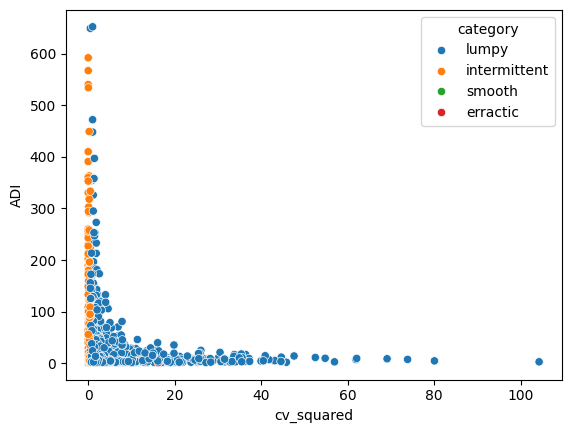

In [8]:
# Plot the demand type
sns.scatterplot(data = adi_cv, x = adi_cv['cv_squared'], y = adi_cv['ADI'], hue = adi_cv['category'])
adi_cv['category'].value_counts()